# How do Indians Vote?

![](https://api.time.com/wp-content/uploads/2014/04/486450555.jpg)

# Introduction to the analysis

India is a country, divided into states and union territories, with a parliamentary system governed under the Constitution of India, which defines the power distribution among the federal government and the states.
Election Commission is a federal body, enacted under the provisions of the Constitution, responsible for monitoring and administering all the electoral processes of India. This body is responsible for ensuring elections are free and fair, without any bias

**The Analysis here is based on the election to Lok Sabha (The General Elections) for the year 2019**
Members of Lok Sabha (House of the People) or the lower house of India's Parliament are elected by being voted upon by all adult citizens of India, from a set of candidates who stand in their respective constituencies. Every adult citizen of India can vote only in their constituency. Candidates who win the Lok Sabha elections are called 'Member of Parliament' and hold their seats for five years or until the body is dissolved by the President on the advice of the council of ministers. The house meets in the Lok Sabha Chambers of the Sansad Bhavan in New Delhi, on matters relating to creation of new laws, removing or improving the existing laws that affect all citizens of India. 

# Presenting an view before going into the Analysis

![](https://upload.wikimedia.org/wikipedia/commons/c/c2/Indian_General_Election_2019.svg)

# Importing the dataset

In [ ]:
pip install geopandas

In [ ]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import sys
from collections import defaultdict
from urllib.request import urlopen
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import widgets
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
from wordcloud import WordCloud , ImageColorGenerator
from PIL import Image
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# # Lets Check out the data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd /content/gdrive/My Drive/Colab Notebooks

In [ ]:
vote=pd.read_csv('election.csv')
vote.head()

# To help our Analysis, lets go for some...

![](https://miro.medium.com/max/500/1*yWFQiGjlgHUVYeh4ELELyw.jpeg)

**Identifying the Null values in the columns**

In [ ]:
vote.isnull().sum()

**Identifying the null entries in the data**

In [ ]:
vote[vote.SYMBOL.isnull()==True]['NAME'].unique()

**Cleaning up the Assets and Liabilities columns**

In [ ]:
def value_cleaner(x):
    try:
        str_temp = (x.split('Rs')[1].split('\n')[0].strip())
        str_temp_2 = ''
        for i in str_temp.split(","):
            str_temp_2 = str_temp_2+i
        return str_temp_2
    except:
        x = 0
        return x
vote['ASSETS'] = vote['ASSETS'].apply((value_cleaner))
vote['LIABILITIES'] = vote['LIABILITIES'].apply((value_cleaner))
vote.head()

**Renaming the columns**

In [ ]:
vote.rename(columns={"CRIMINAL\nCASES": "CRIMINAL CASES", "GENERAL\nVOTES": "GENERAL VOTES", "POSTAL\nVOTES": "POSTAL VOTES","TOTAL\nVOTES": "TOTAL VOTES","OVER TOTAL ELECTORS \nIN CONSTITUENCY": "OVER TOTAL ELECTORS IN CONSTITUENCY","OVER TOTAL VOTES POLLED \nIN CONSTITUENCY": "OVER TOTAL VOTES POLLED IN CONSTITUENCY"}, inplace=True)
vote.head()

**Cleaning up the Educational Qualification of the election contestants**

In [ ]:
vote.EDUCATION.unique()

In [ ]:
vote.EDUCATION.replace({'Post Graduate\n':'Post Graduate'},inplace=True)
vote.EDUCATION.unique()

**Identifying the Data Type of the columns**

In [ ]:
vote.dtypes

**Identifying Discrepancy entries in the columns**

In [ ]:
vote[vote['CRIMINAL CASES']=='Not Available'].head()

**Updating the data types for the analysis**

In [ ]:
vote['ASSETS']=pd.to_numeric(vote['ASSETS'])
vote['LIABILITIES']=pd.to_numeric(vote['LIABILITIES'])
vote['CRIMINAL CASES'].replace({np.NaN:0})
vote['CRIMINAL CASES'] = pd.to_numeric(vote['CRIMINAL CASES'], errors='coerce').fillna(0).astype(np.int64)

# The Analysis

# State and Constituency Level Analysis

# What is the distribution of Constituencies over all the states?

In [ ]:
st_con=vote.groupby('STATE').apply(lambda x:x['CONSTITUENCY'].nunique()).reset_index(name='# Constituency')
shp_gdf = gpd.read_file('Indian_States.shp')
merged = shp_gdf.set_index('st_nm').join(st_con.set_index('STATE'))
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('State-wise Distribution of Indian Constituencies',
             fontdict={'fontsize': '15', 'fontweight' : '3'})
fig = merged.plot(column='# Constituency', cmap='inferno_r',linewidth=0.5, ax=ax, edgecolor='0.2',legend=True)
st_con.sort_values(by='# Constituency',ascending=False,inplace=True)
fig2 = px.bar(st_con, x='STATE', y='# Constituency',
                     color='# Constituency',
             labels={'pop':'Constituencies of India'})
fig2.update_layout(title_text='Statewise distribution of the Constituencies all over India',template='plotly_dark')
fig2.show()

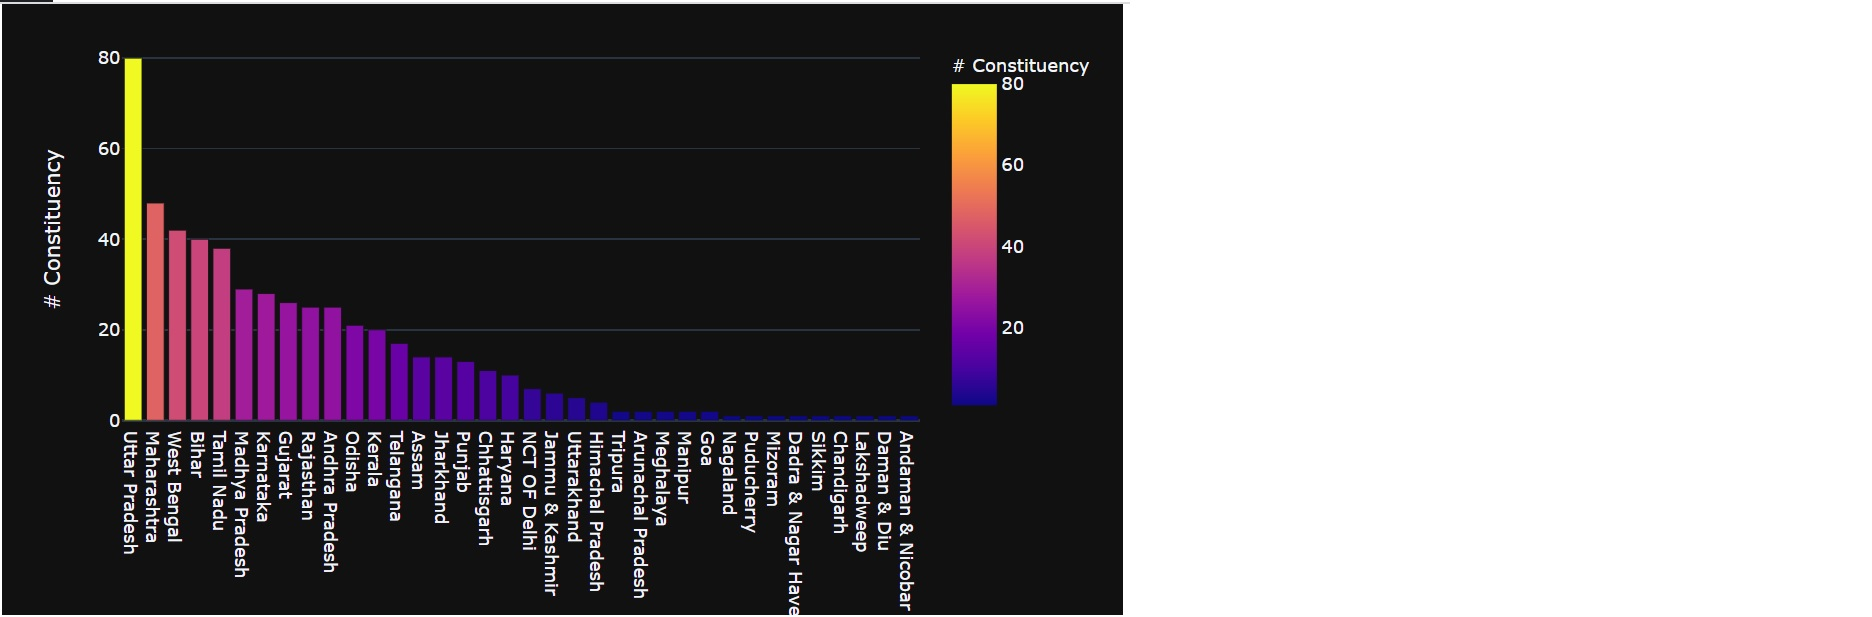

**Observation** Uttar Pradesh, Maharashtra and West Bengal- The states have the most number of constituencies. There exists a direct relationship of count of constituencies and population- The constituencies are divided based on the population of 1971- and this shall remain till the year 2026. Although currently Bihar has a higher population, West Bengal has the 3rd highest constituency count based on the above fact.

# Lets create a Sunburst image of all the States and Constituencies

In [ ]:
st_con_vt=vote[['STATE','CONSTITUENCY','TOTAL ELECTORS']]
fig = px.sunburst(st_con_vt, path=['STATE','CONSTITUENCY'], values='TOTAL ELECTORS',color='TOTAL ELECTORS',color_continuous_scale='viridis_r')
fig.update_layout(title_text='Sunburst Image of State and Constituency by Voters',template='plotly_dark')
fig.show()

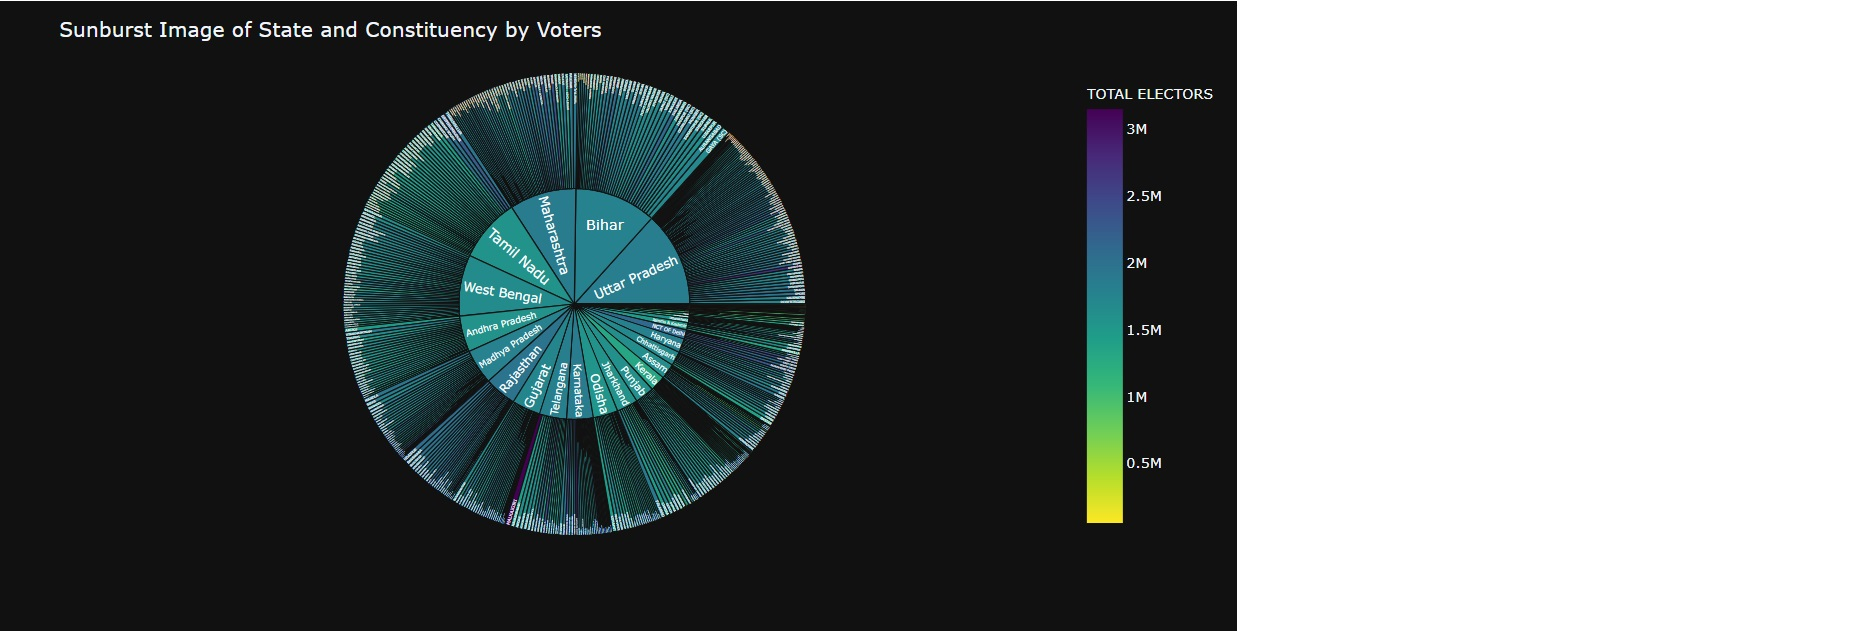

# Party Level Analysis

# Which Parties have been present in most constituencies and States?

In [ ]:
vote_prty=vote[vote['PARTY']!='NOTA']
prty_cnt=vote_prty.groupby('PARTY').apply(lambda x:x['CONSTITUENCY'].count()).reset_index(name='# Constituency')
prty_st=vote_prty.groupby('PARTY').apply(lambda x:x['STATE'].nunique()).reset_index(name='# State')
prty_cnt.sort_values(by='# Constituency',ascending=False,inplace=True)
prty_top_cn=prty_cnt[:25]
prty_top_all=pd.merge(prty_top_cn,prty_st,how='inner',left_on='PARTY',right_on='PARTY')
fig = px.scatter(prty_top_all, x='# Constituency', y='# State', color='# State',size='# Constituency', hover_data=['PARTY'])
fig.update_layout(title_text='Constituency vs Statewise participation for the most contesting Political Parties',template='plotly_dark')
fig.show()

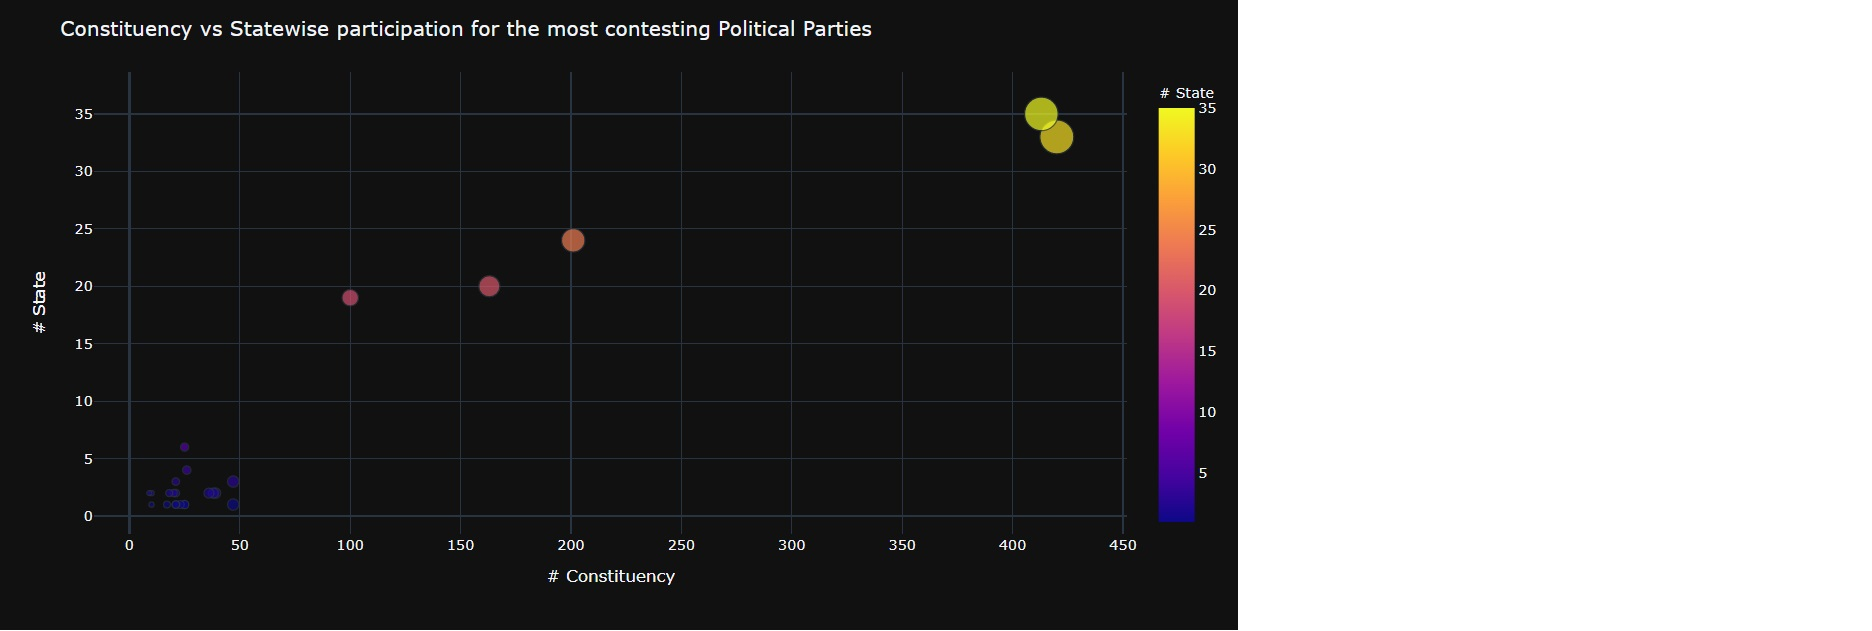

**Observation** The Bharatiya Janata Party (BJP) and Indian National Congress (INC) have participated in the most number of constituencies all over India. While BJP leads in the number of constituency contested, INC wins in terms of the number of States. While these are the major parties to contest almost all over India, we see the rest of the parties have restricted themselves to a handfull of states.

# What has been the performance of the Parties Statewise?

In [ ]:
st_prty=vote_prty.groupby(['PARTY','STATE']).apply(lambda x:x['WINNER'].sum()).reset_index(name='Wins')
pvt_st_prty=pd.pivot(st_prty,index='PARTY',columns='STATE',values='Wins')
plt.figure(figsize=(15,35))
sns.heatmap(pvt_st_prty,annot=True,fmt='g',cmap='terrain')
plt.xlabel('States',size=20)
plt.ylabel('Party',size=20)
plt.title('Statewise report card for the Political Parties in India',size=25)

# Which party has won the most constituencies?

In [ ]:
part_win=vote.groupby('PARTY').apply(lambda x:x['WINNER'].sum()).reset_index(name='# Wins')
part_win.sort_values(by='# Wins',ascending=False,inplace=True)
top_part_win=part_win[0:15]
fig = px.bar(top_part_win, x='PARTY', y='# Wins',
                     color='# Wins',title='Win Counts by a Political Party in 2019')
fig.update_layout(title_text='Win Counts by a Political Party in 2019',template='plotly_dark')
fig.show()

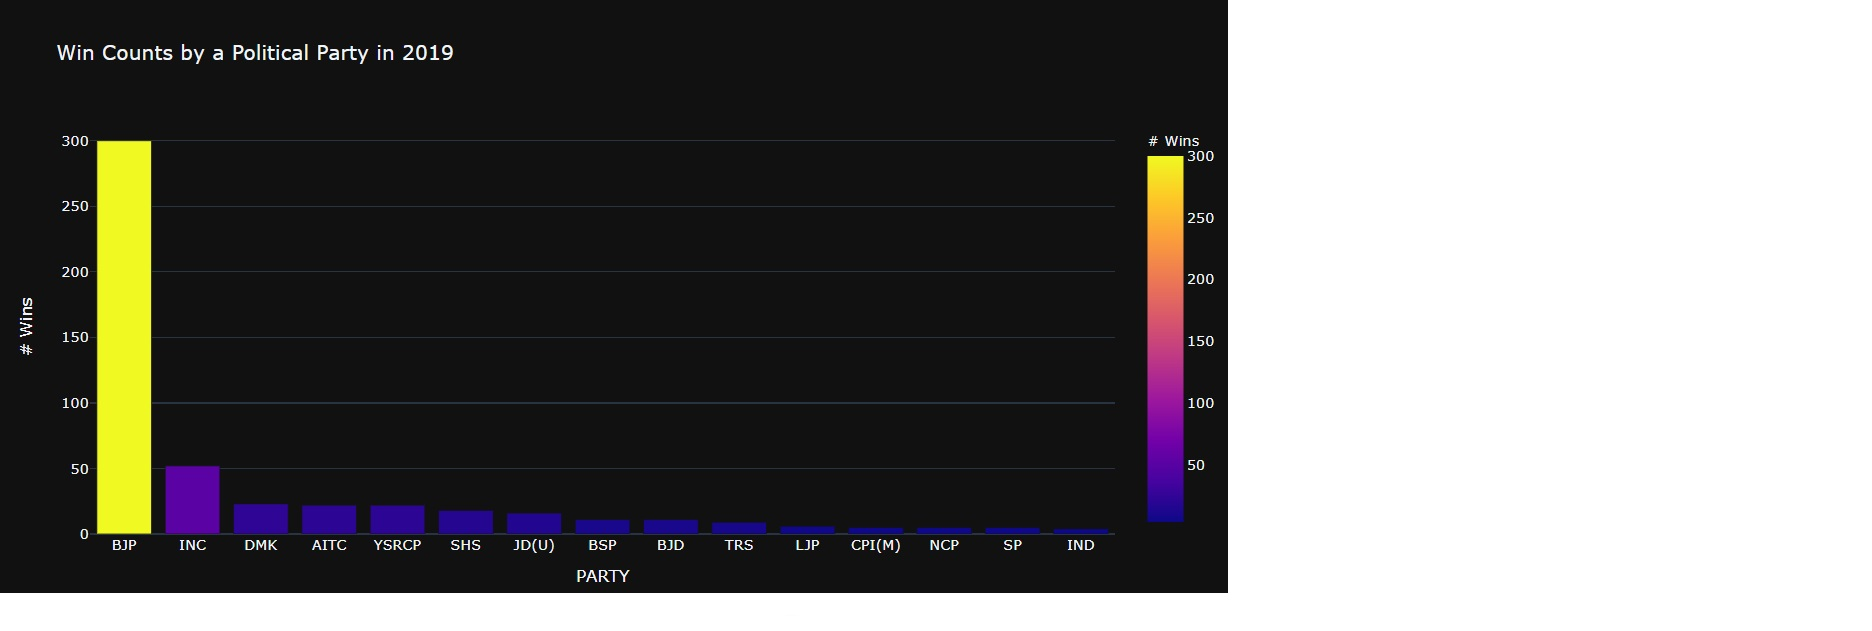

**Observation** As seen from the data, In 2019, BJP has won the maximum constituencies all over India. The Image below the introduction also suggests the same. The distribution of all the parties is presented below. INC, who stood 2nd in the number of victories had only 52, which is practically 1/6th of the constituencies won by BJP

# What has been the general Win vs Loss relationship for the Parties in 2019?

In [ ]:
prty_cnt_win=pd.merge(prty_cnt,part_win,how='inner',left_on='PARTY',right_on='PARTY')
prty_cnt_win['Lost']=prty_cnt_win['# Constituency']-prty_cnt_win['# Wins']
prty_wins_cnt=prty_cnt_win[['PARTY','# Wins']]
prty_wins_cnt['Verdict']='Constituency Won'
prty_loss_cnt=prty_cnt_win[['PARTY','Lost']]
prty_loss_cnt['Verdict']='Constituency Lost'
prty_wins_cnt.columns=['Party','Counts','Verdict']
prty_loss_cnt.columns=['Party','Counts','Verdict']
top_prty_wins_cnt=prty_wins_cnt[:15]
prty_loss_cnt_cnt=prty_loss_cnt[:15]
prt_win_loss=pd.concat([top_prty_wins_cnt,prty_loss_cnt_cnt])
fig = px.bar(prt_win_loss, x='Party', y='Counts', color='Verdict')
fig.update_layout(title_text='Win vs Loss Analysis for the Top Parties',template='plotly_dark')
fig.show()

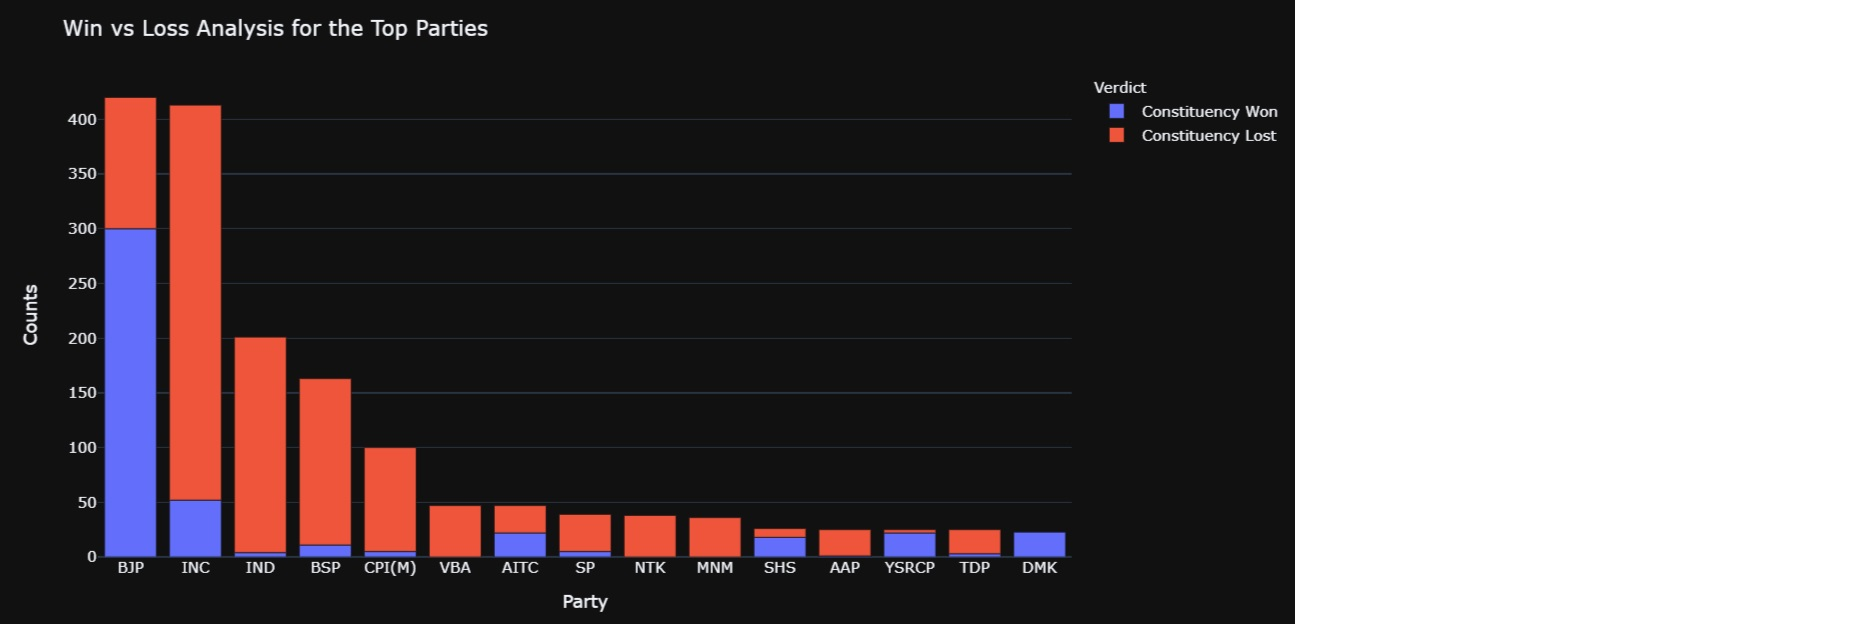

**Observation** As seen in the above chart, the 2019 elections have been extremely lucky for parties like BJP,SHS or DMK. But it has been a major failure for the rest of the parties, where they have lost more than they won.

# Politician Level Analytics

# What is the Gender Ratio of the Contestants? Also the Gender Ratio of the Winners?

In [ ]:
vote_gndr=vote[vote['PARTY']!='NOTA']
gndr_overall=vote_gndr.groupby('GENDER').apply(lambda x:x['NAME'].count()).reset_index(name='Counts')
gndr_overall['Category']='Overall Gender Ratio'
winners=vote_gndr[vote_gndr['WINNER']==1]
gndr_winner=winners.groupby('GENDER').apply(lambda x:x['NAME'].count()).reset_index(name='Counts')
gndr_winner['Category']='Winning Gender Ratio'
gndr_overl_win=pd.concat([gndr_winner,gndr_overall])
fig = px.bar(gndr_overl_win, x='GENDER', y='Counts',
             color='Category', barmode='group')
fig.update_layout(title_text='Participation vs Win Counts analysis for the Genders',template='plotly_dark')
fig.show()

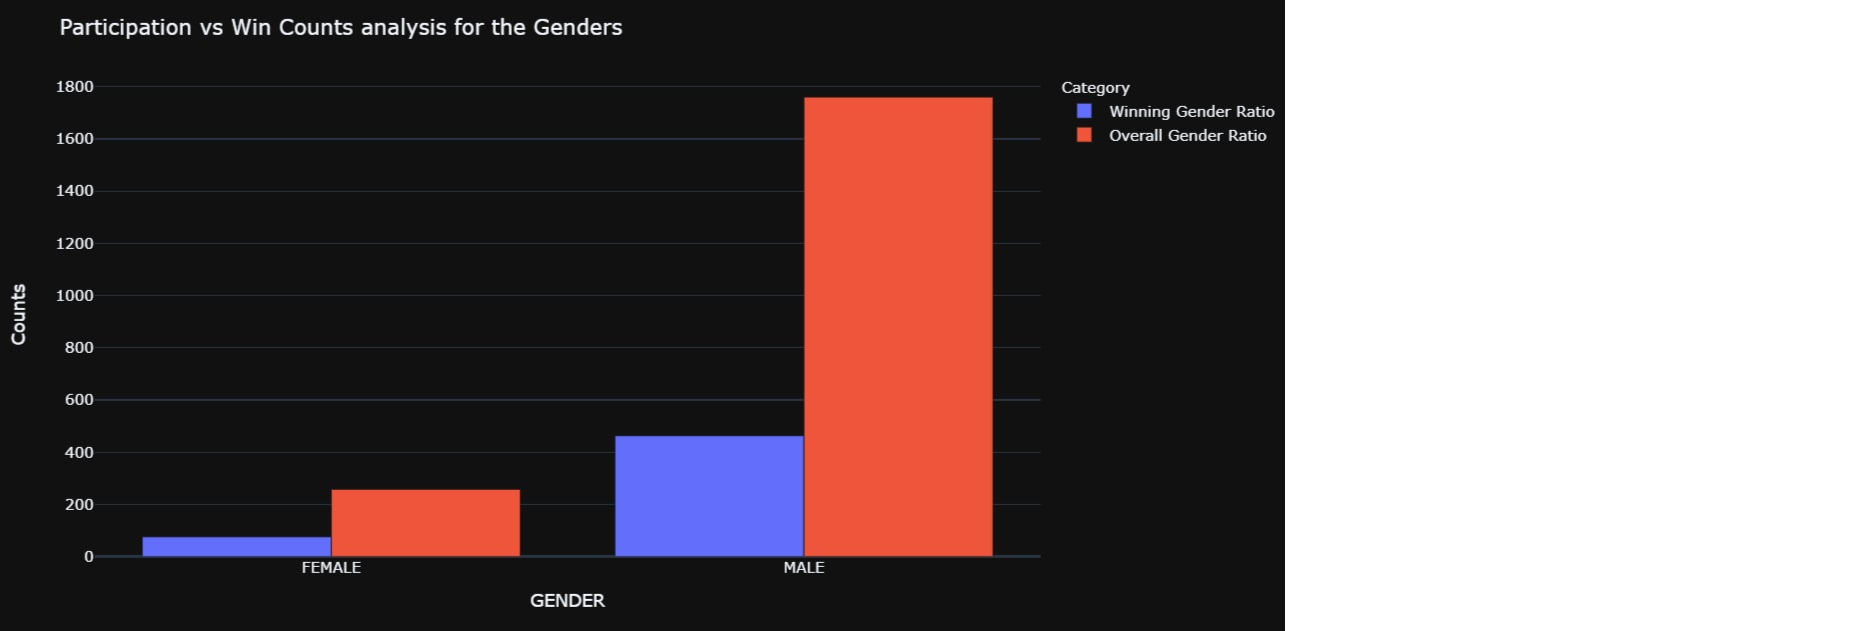

**Observation** Out of the total list of participants only 12.78% (258 out of 2018) are female politicians, while 87.21% (1760 out of 2018) are male. Upon considering the winners, 14.1% (76 out of 463) are female politicians, while 85.9% are male politicians. The Gender ratio is not very well distributed as can be seen from the above presentation.

# What is the Educational Qualification of our politicians?

In [ ]:
ed_valid=vote[vote['PARTY']!="NOTA"]
ed_cnt=ed_valid.groupby('EDUCATION').apply(lambda x:x['PARTY'].count()).reset_index(name='Counts')
fig = go.Figure(data=[go.Pie(labels=ed_cnt['EDUCATION'], values=ed_cnt['Counts'], pull=[0.1, 0.2, 0, 0.1, 0.2, 0,0.1, 0.2, 0,0.1, 0.2, 0.1])])
fig.update_layout(title_text='Overall Education Qualification of all the Nominees',template='plotly_dark')
fig.show()
ed_won=ed_valid[ed_valid['WINNER']==1]
ed_win_cnt=ed_won.groupby('EDUCATION').apply(lambda x:x['PARTY'].count()).reset_index(name='Counts')
fig2 = go.Figure(data=[go.Pie(labels=ed_win_cnt['EDUCATION'], values=ed_win_cnt['Counts'], pull=[0.1, 0.2, 0, 0.1, 0.2, 0,0.1, 0.1, 0.2,0, 0.1, 0.2],title='Education Qualification of the Winners')])
fig2.update_layout(title_text='Education Qualification of the Winners',template='plotly_dark')
fig2.show()

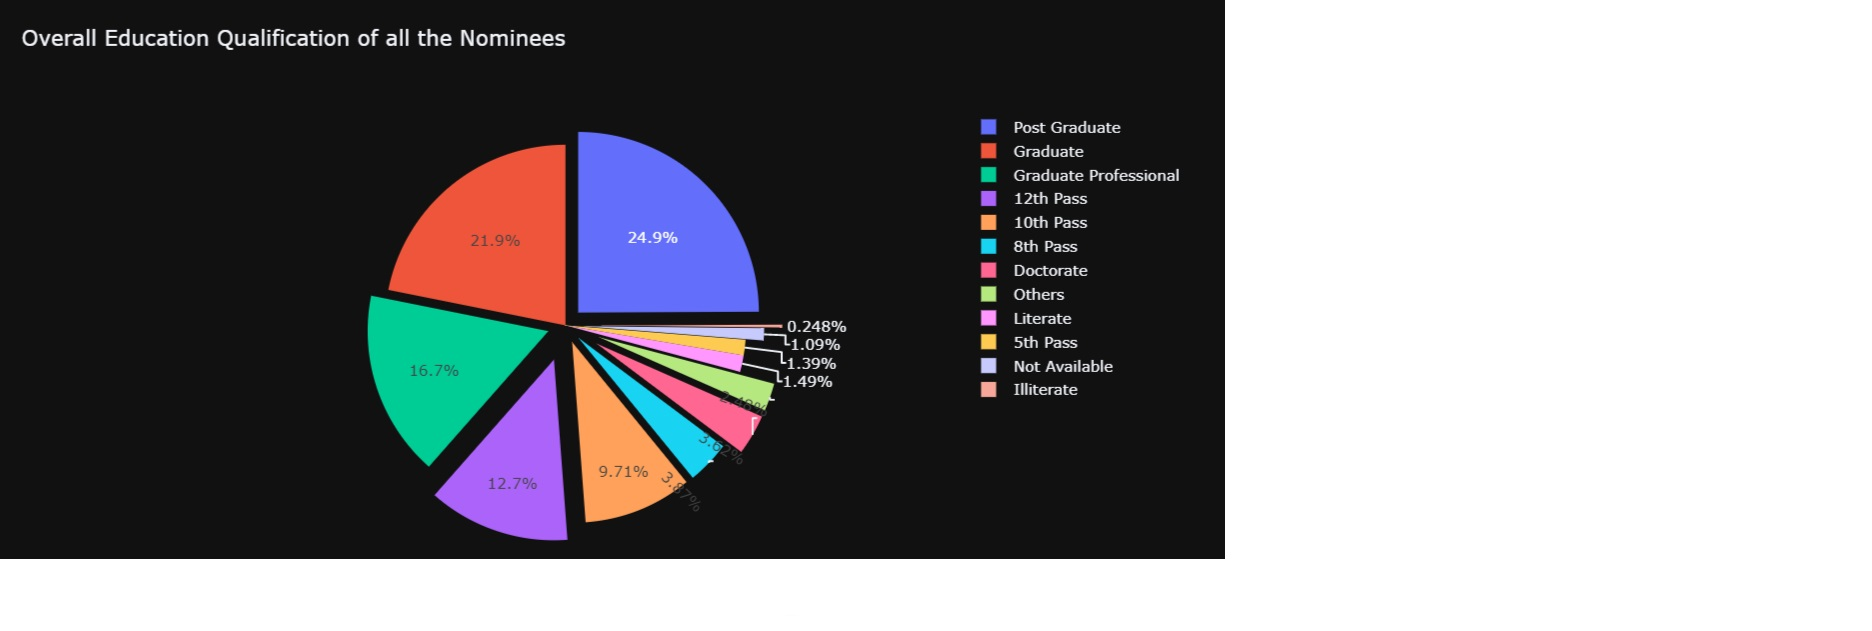

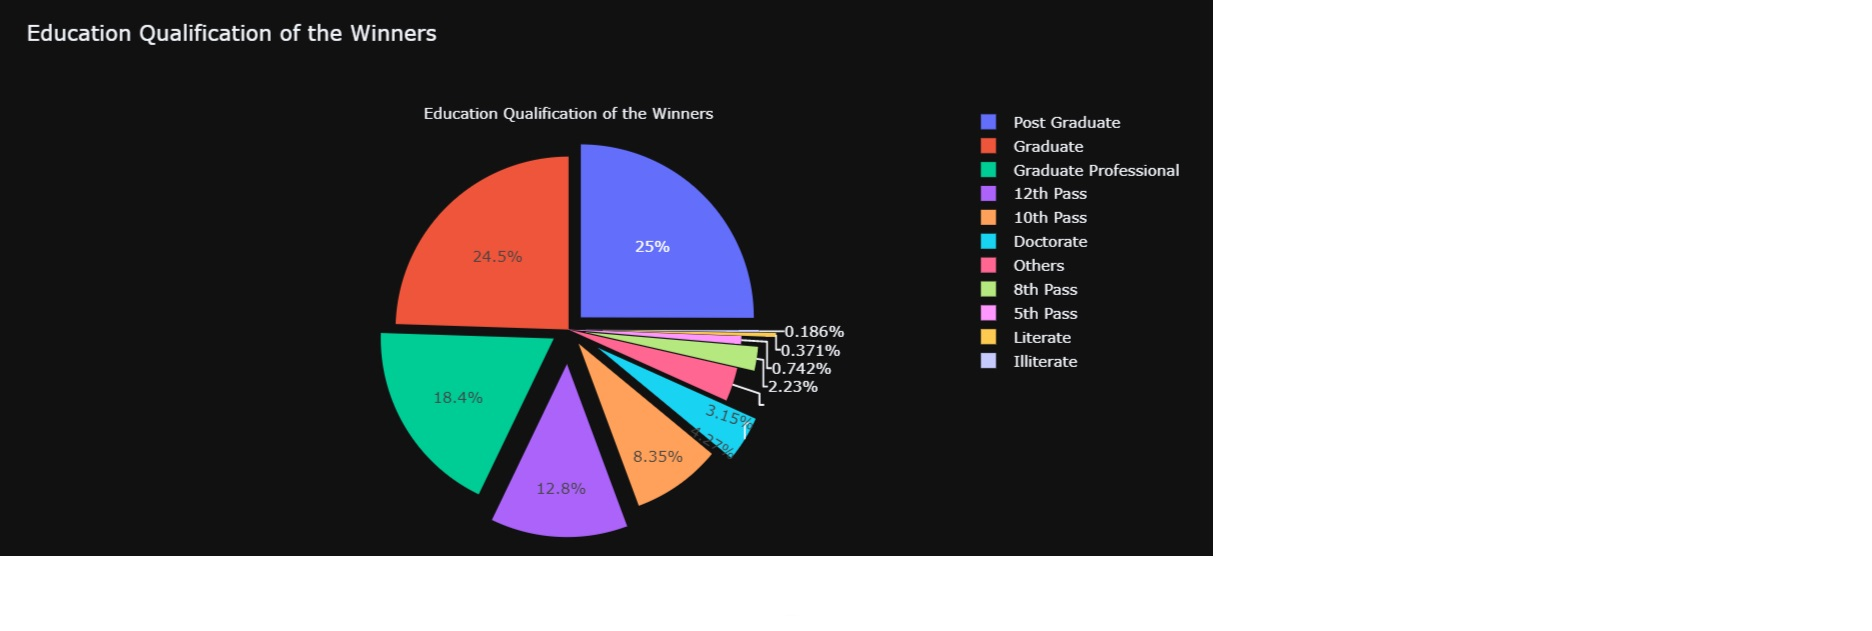

**Observation** The total percentage of Graduate+ educated people contesting in the election is 67.12%, which has increased to 72.17% of the winners. This is actually a positive sign, as educated politicians are a very big factor towards a country's development. But still around 28% of the politicians have received no professional degree. Hope with passing time, we improve upon this factor, and consider the educational qualification as a primary requirement while voting!

# What is the relationship of Age and Politics?

In [ ]:
age_cnt=ed_valid.groupby(['AGE','GENDER']).apply(lambda x:x['NAME'].count()).reset_index(name='Counts')
fig = px.histogram(age_cnt, x="AGE",y='Counts',color='GENDER',marginal='violin',title='Age Counts Distribution among the politicians')
fig.update_layout(title_text='Age Counts Distribution among the politicians',template='plotly_dark')
fig.show()

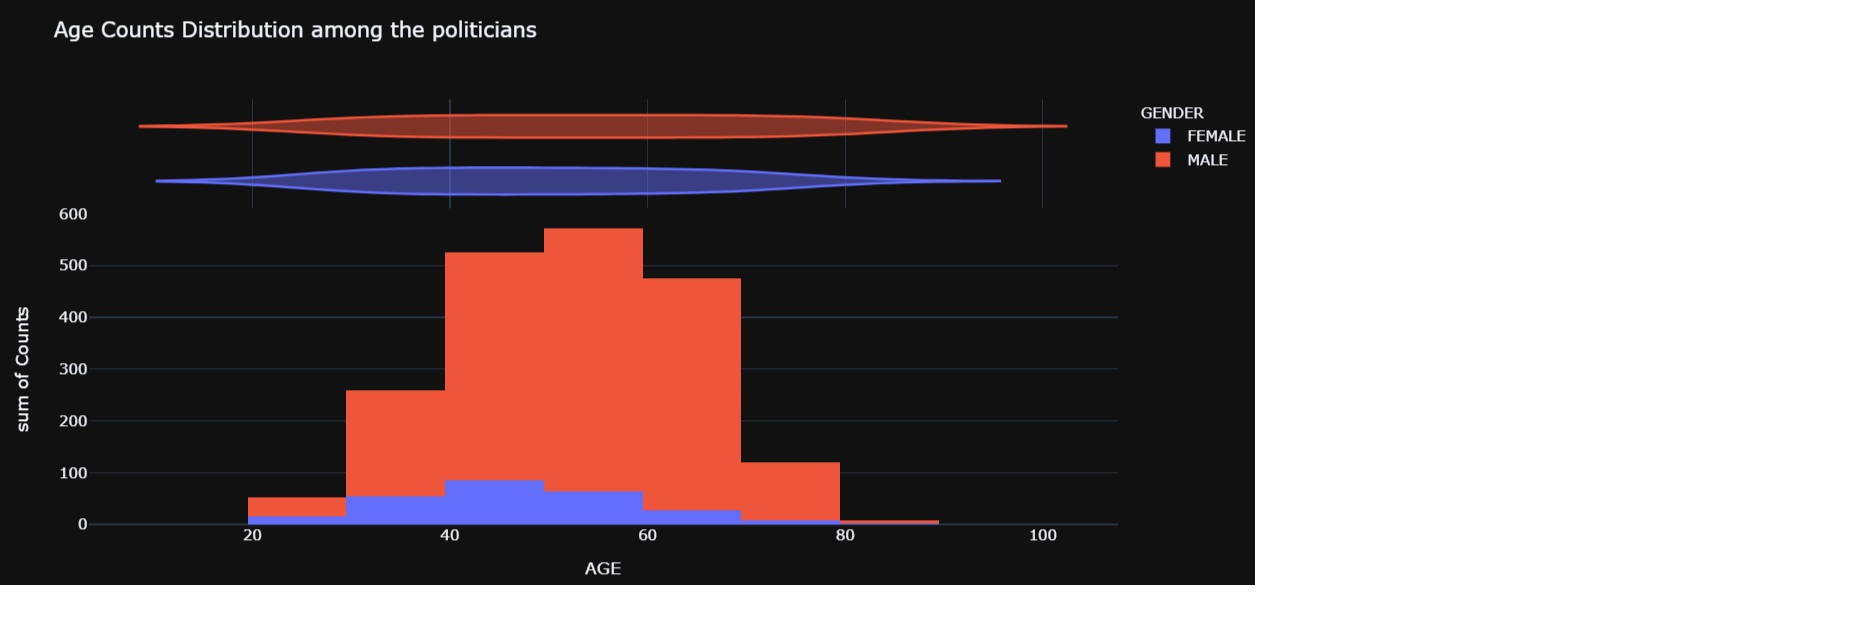

**Observation** Most Number of female politicians have their average age between 45-50, while for male politician, it ranges from 50-60 range. The average age of male politians is more as compared to female politicians contesting for the Lok Sabha elections.

# What relation does the Politician category have with the election results?

In [ ]:
vote_cat=vote[vote['PARTY']!='NOTA']
cat_overall=vote_cat.groupby('CATEGORY').apply(lambda x:x['NAME'].count()).reset_index(name='Counts')
cat_overall['Category']='Overall Category Counts'
winners_cat=vote_gndr[vote_gndr['WINNER']==1]
cat_winner=winners_cat.groupby('CATEGORY').apply(lambda x:x['NAME'].count()).reset_index(name='Counts')
cat_winner['Category']='Winning Category Ratio'
cat_overl_win=pd.concat([cat_winner,cat_overall])
fig = px.bar(cat_overl_win, x='CATEGORY', y='Counts',
             color='Category', barmode='group')
fig.update_layout(title_text='Participation vs Win Counts for the Category in Politics',template='plotly_dark')
fig.show()

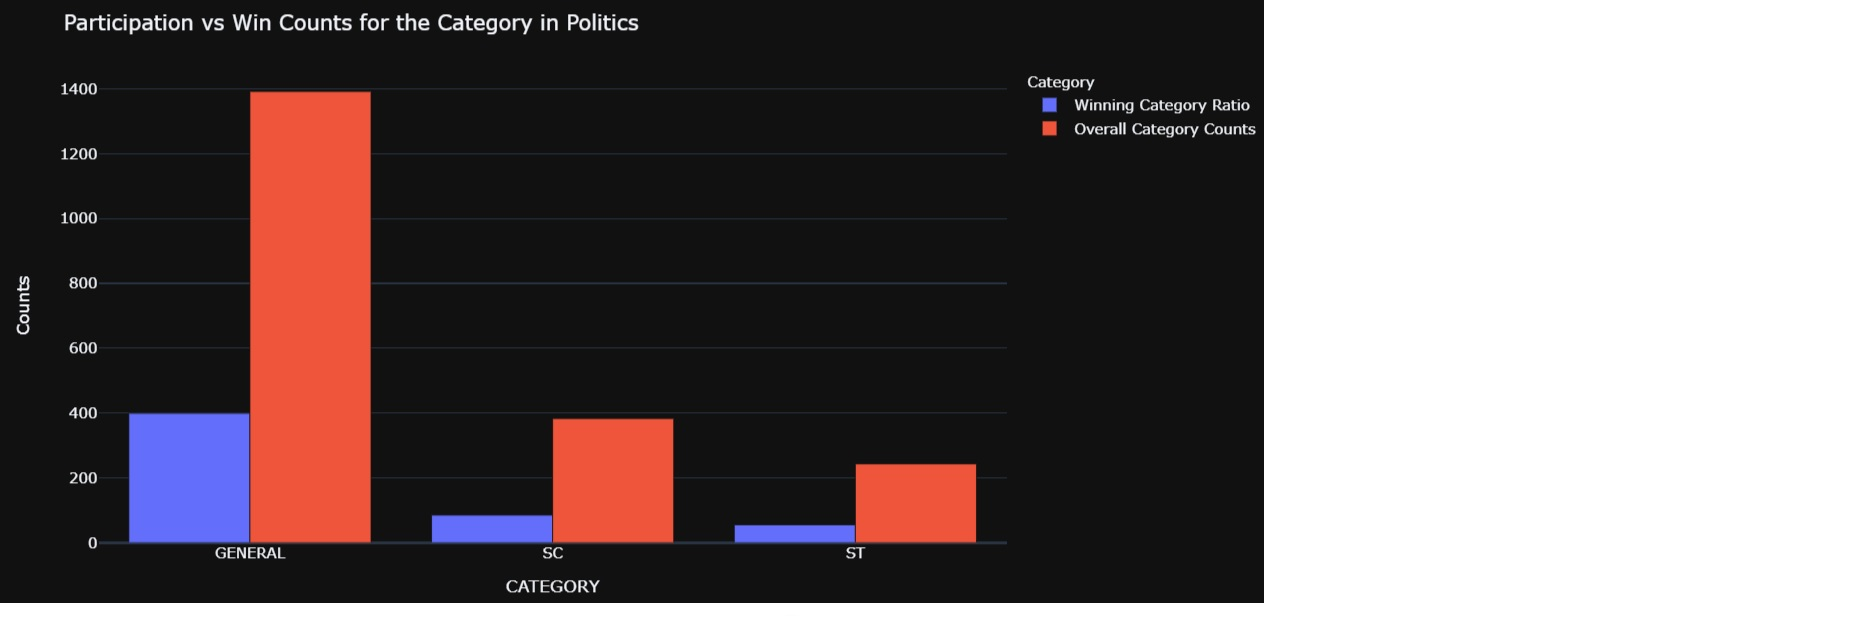

**Observation** The Category participation of General-SC-ST have been in the ratio of 68.97:18.97:12.04- while as of the winners, the ratios have been modified to 74.02:15.76:10:20

# Have the politicians been involved with criminal activities?

In [ ]:
crim_cnt=ed_valid.groupby('CRIMINAL CASES').apply(lambda x:x['NAME'].count()).reset_index(name='Counts')
fig = px.histogram(crim_cnt, x='CRIMINAL CASES',y='Counts',marginal='violin')
fig.update_layout(title_text='Criminal Cases Counts Distribution among the politicians',template='plotly_dark')
fig.show()

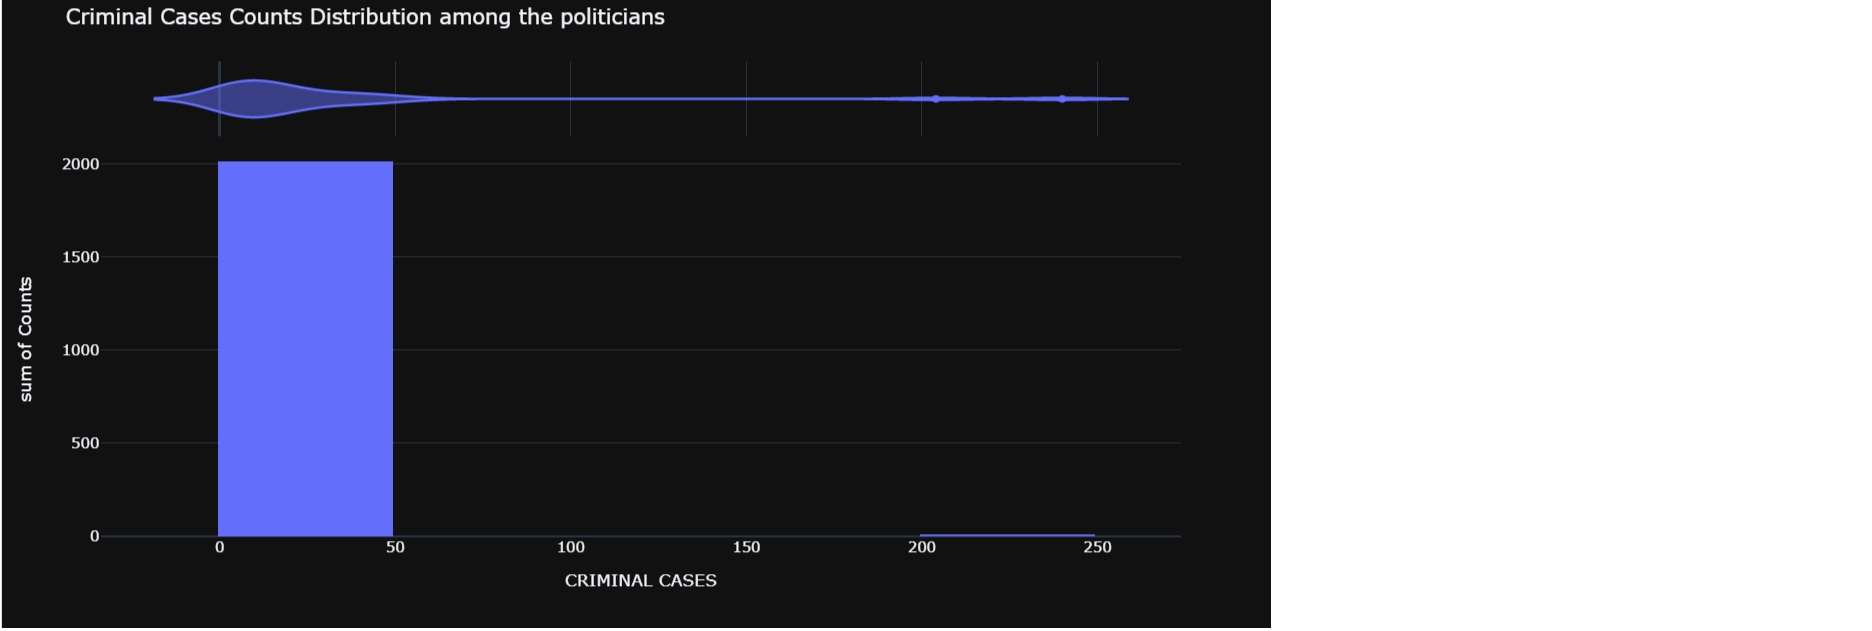

**Observations** Many politicians have been associated with criminal activities. Always these cases pressed need not be genuine, but obviously, when its multiple- this is a serious issue. We must take the responsibility while voting, as its our duty to choose the right person- as a duty towards the nation.

# Plotting the Assets vs Liabilities amount for Winning Politicians (Plotted w.r.t State)

In [ ]:
as_liab_name=ed_valid[['NAME','PARTY','ASSETS','LIABILITIES','STATE','CONSTITUENCY','WINNER']]
as_liab_name.WINNER.replace({1:'Yes',0:'No'},inplace=True)
win_as_liab_name=as_liab_name[as_liab_name['WINNER']=='Yes']
win_as_liab_name.sort_values(by='ASSETS',ascending=False,inplace=True)
fig = px.scatter(win_as_liab_name, x='ASSETS', y='LIABILITIES', 
                 color='STATE',size='ASSETS', 
                 hover_data=(['NAME','PARTY','CONSTITUENCY','STATE','WINNER']),
                 title='Assets vs Liabilities for the Winning Politicians')
fig.update_layout(title_text='Assets vs Liabilities for the Winning Politicians',template='plotly_dark')
fig.show()

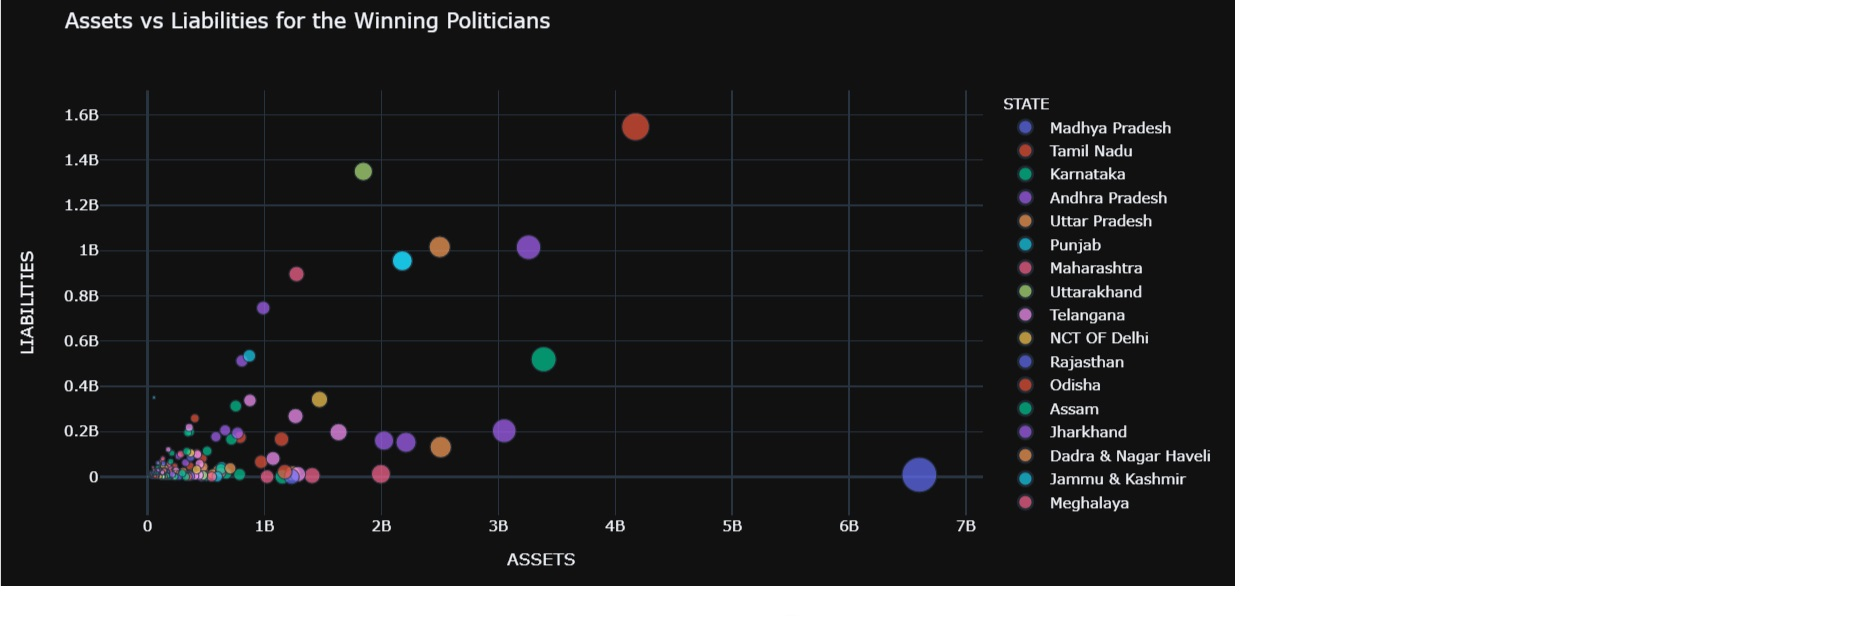

**Observations** The assets and liabilities of the Winning politicians have been plotted. The parameters vary largely depending on the business/services they are associated with besides politics.
No valid correlation could be inferred with respect to assets and liabilities.

# Prediction

**Note-** We shall use Random Classifier to predict the results of the election.

In [ ]:
vote_df=vote[vote['PARTY']!='NOTA']
vote_df['GENDER'].replace({'MALE':1,'FEMALE':2},inplace=True)
vote_df['CATEGORY'].replace({'GENERAL':1,'SC':2,'ST':3},inplace=True)
i=1
parties_dict={}
for j in vote_df['PARTY']:
    if j in parties_dict:
        continue
    else:
        parties_dict[j]=i
        i+=1
vote_df['PARTY'].replace(parties_dict,inplace=True)
a=1
edu_dict={}
for b in vote_df['EDUCATION']:
    if b in edu_dict:
        continue
    else:
        edu_dict[b]=a
        a+=1
vote_df['EDUCATION'].replace(edu_dict,inplace=True)
df1 = vote_df[['STATE','CONSTITUENCY','WINNER','PARTY','SYMBOL','GENDER','CRIMINAL CASES','AGE','CATEGORY','EDUCATION','TOTAL VOTES','TOTAL ELECTORS','ASSETS','LIABILITIES']]
num_cols = ['PARTY','EDUCATION','CRIMINAL CASES','AGE','TOTAL VOTES','TOTAL ELECTORS','ASSETS','CATEGORY','LIABILITIES','GENDER']
dataset = pd.get_dummies(df1)
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
scaling_columns = num_cols
dataset[scaling_columns] = standardScaler.fit_transform(dataset[scaling_columns])
dataset.head()

In [ ]:
df_not_winner = dataset[dataset.WINNER == 0]
df_winner = dataset[dataset.WINNER == 1]
df_winner_upsampled = resample(df_winner, replace = True,n_samples = 1452, random_state = 0) 
df_total_upsampled = pd.concat([df_not_winner, df_winner_upsampled])
df_total_upsampled.WINNER.value_counts()
y = df_total_upsampled['WINNER']
X = df_total_upsampled.drop(['WINNER'], axis = 1)
rf_scores = []
for k in range(1,60):
    randomforest_classifier= RandomForestClassifier(n_estimators=k,random_state=0)
    score=cross_val_score(randomforest_classifier,X,y,cv=10)
    rf_scores.append(score.mean())
fig=px.scatter(x=[k for k in range(1, 60)],y= rf_scores,color=rf_scores,size=rf_scores)
fig.update_layout(title_text='Assets vs Liabilities for the Winning Politicians',template='plotly_dark')
fig.show()

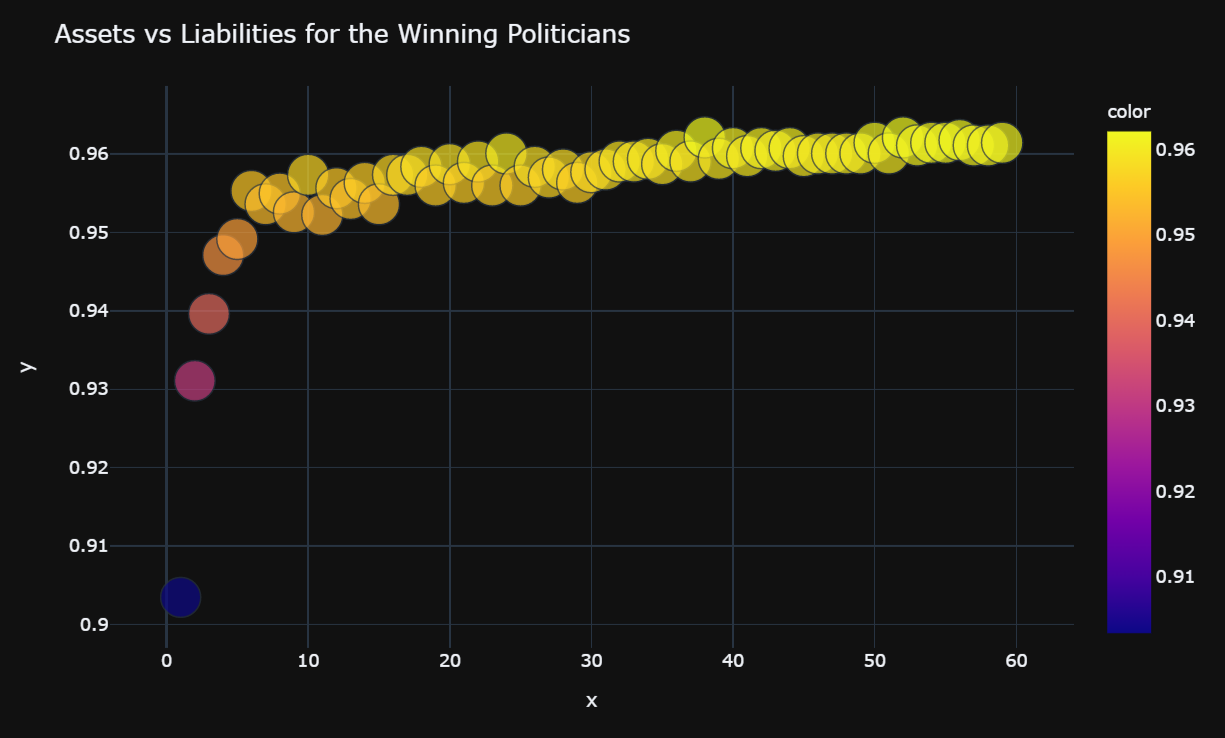

**Observation** As seen from the above scatter plot, for tge value of k=38, we get the highest accuracy values. We shall be using the same for our model's prediction

In [ ]:
randomforest_classifier= RandomForestClassifier(n_estimators=38,random_state=0)
score=cross_val_score(randomforest_classifier,X,y,cv=10)
print('% Accuracy :', round(score.mean()*100,4))

**Observation** We have reached an accuracy percentage of 96.21% with our model. Will work on to improve the model further- to increase the accuracy.

#SUMMARY 

After analyzing the voting pattern of Indians, we have come upon multiple conclusions. Let us look at them in the below points:

1)In 2019, the Bharatiya Janata Party (BJP) has claimed the most number of seats all over India- dominating clearly over all the national and the satte specific parties. The outreach created by them has really made them claim their position in the Lok Sabha.\
2)Gerneally, education is regarded as a significant factor while voting. Arounf 72%+ of the winners are having a gradutae + degree. This is a significant factor for a developing nation like India- where we need educated politicians to lead the nation.\
3)The general paticipation of Female politicians is much less than the male politicians. A balanced gander ratio would be good enough- as people from all sectors would be able to contribute to the progress of the society.\
4)The average age of polticians is high. It might be an advantage if younger politicians contest and are able to lead the nation. Altough is is never a parameter to think that the older politicians wouldn't be able to perform their tasks well- but it comes with the risk of health and age related issues.\
5)Criminal activities is a serious concern- as the people who are elected by us- indirectly are the face of the nation. They should be more of a role model-rather than someone who is not respected.\
6)As our prediction suggestes, we have reached an accuracy of 96.2% in estimating the winning participants using Random classifier model. We shall work upon to improve this model further in the future updates

#About the data

1) The data is very good- cleaned and well presented. Need to just have some further checks upon the validity. We have found some discrepancies in the data which We will be sharing.\
2) Some data types and columns needed basic cleaning which we have done as seen above.\
3) Overall it gives us a good sense about Indian poltical scenerio and what factors should we consider while we choose our representative. Its our reponsibility to choose the right candidates, such that they can make the difference!

# EXTRA MODULE FOR REVIEW 3

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import NearestNeighbors,KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
l = vote.select_dtypes('object').columns
lb = LabelEncoder()
for i in l:
    vote[i] = lb.fit_transform(vote[i])

In [ ]:
vote.drop(['Name'],axis=1,inplace=True)
X = vote.drop('Winner',axis=1)
y = vote['Winner']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
models = [["LogisticRegression",LogisticRegression()],["DecisionTreeClassifier",DecisionTreeClassifier()],["ExtraTreeClassifier",ExtraTreeClassifier()],["GaussianNB",GaussianNB()],["KNeighborsClassifier",KNeighborsClassifier()]]
model_prediction = []

In [ ]:
for i in models:
    model = i[1]
    model.fit(X_train,y_train)
    predict = model.predict(X_test)
    score = (accuracy_score(predict,y_test))
    model_prediction.append([i[0],score])

In [ ]:
model_prediction = pd.DataFrame(model_prediction)
model_prediction.columns = ["Model Name","Score"]
model_prediction.sort_values(by='Score',ascending=False)

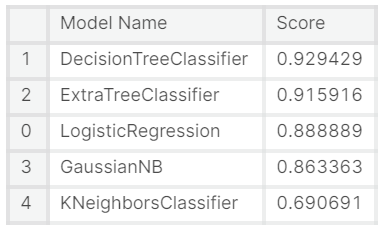